In [26]:
# import the right modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

In [27]:
# read the data
data = pd.read_csv('bank.csv', sep=';').drop_duplicates()
print(data.head())
print(data.info())

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #  

In [28]:
# Data cleaning and pre-processing
# check for missing values
print(data.isna().sum())
print(data.dtypes)


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


In [29]:
# get the descriptive statistics of the data
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


# Data visualization
Visualize categorical and non-categorical data for better understanding

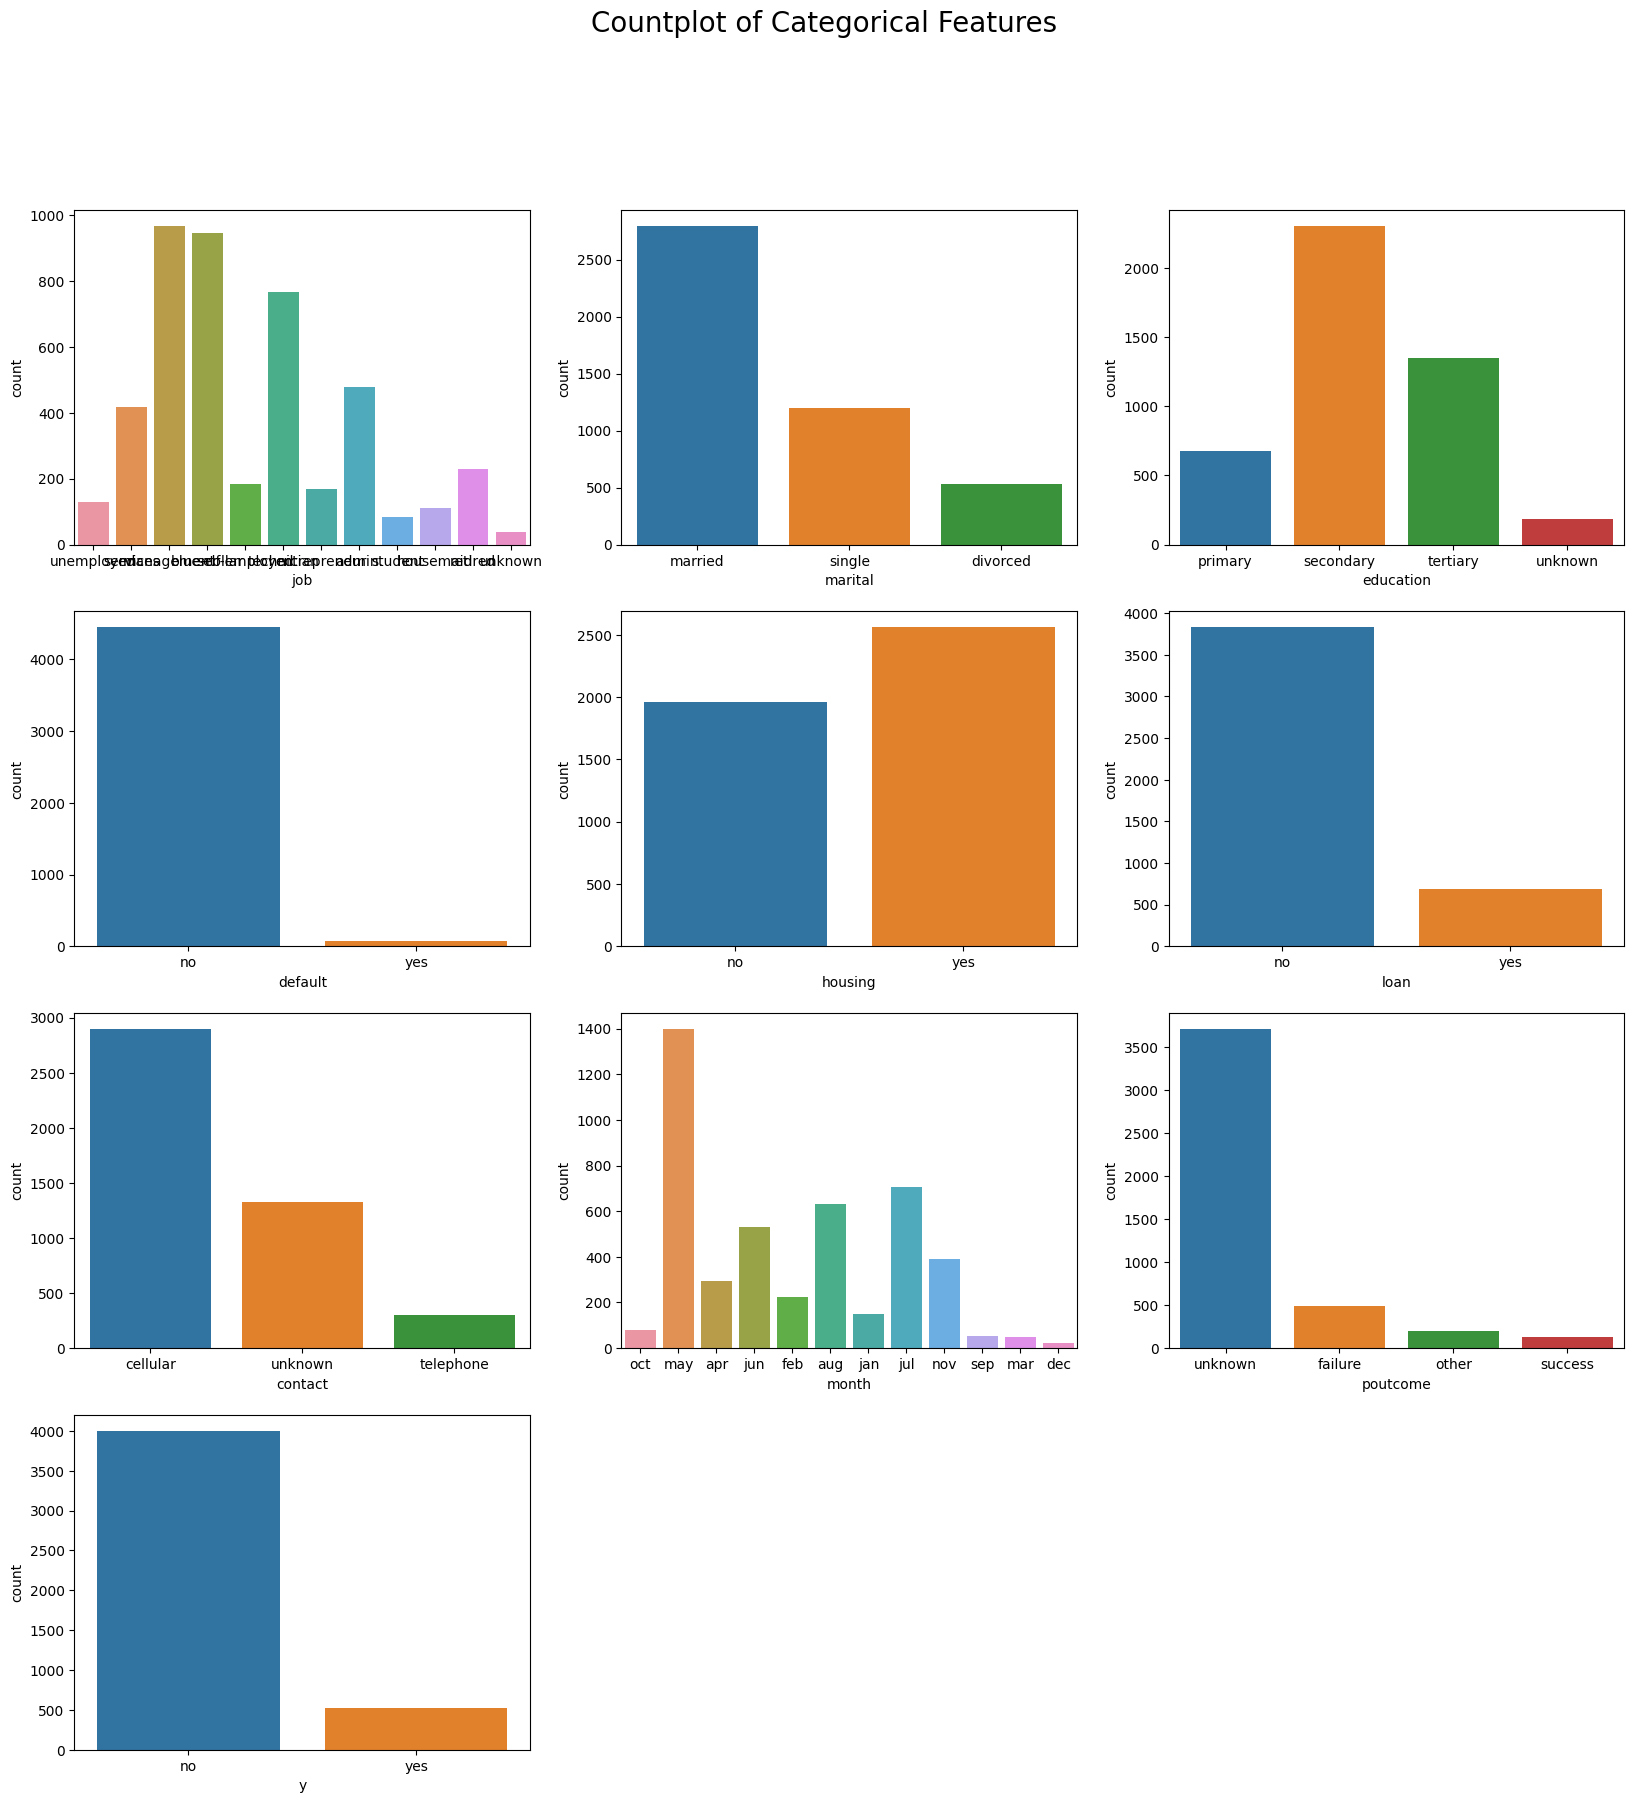

In [30]:
# get the countplot for categorical features
category_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
# create subplots to allow printing of all the countplots in one figure 
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# loop through the category features and plot the countplot
for category in category_features:
    sns.countplot(x=category, data=data, ax=axes[category_features.index(category) // 3, category_features.index(category) % 3])
for i in range(len(category_features), len(axes.flat)):
    fig.delaxes(axes.flatten()[i])

plt.suptitle('Countplot of Categorical Features', fontsize=20)
plt.show()



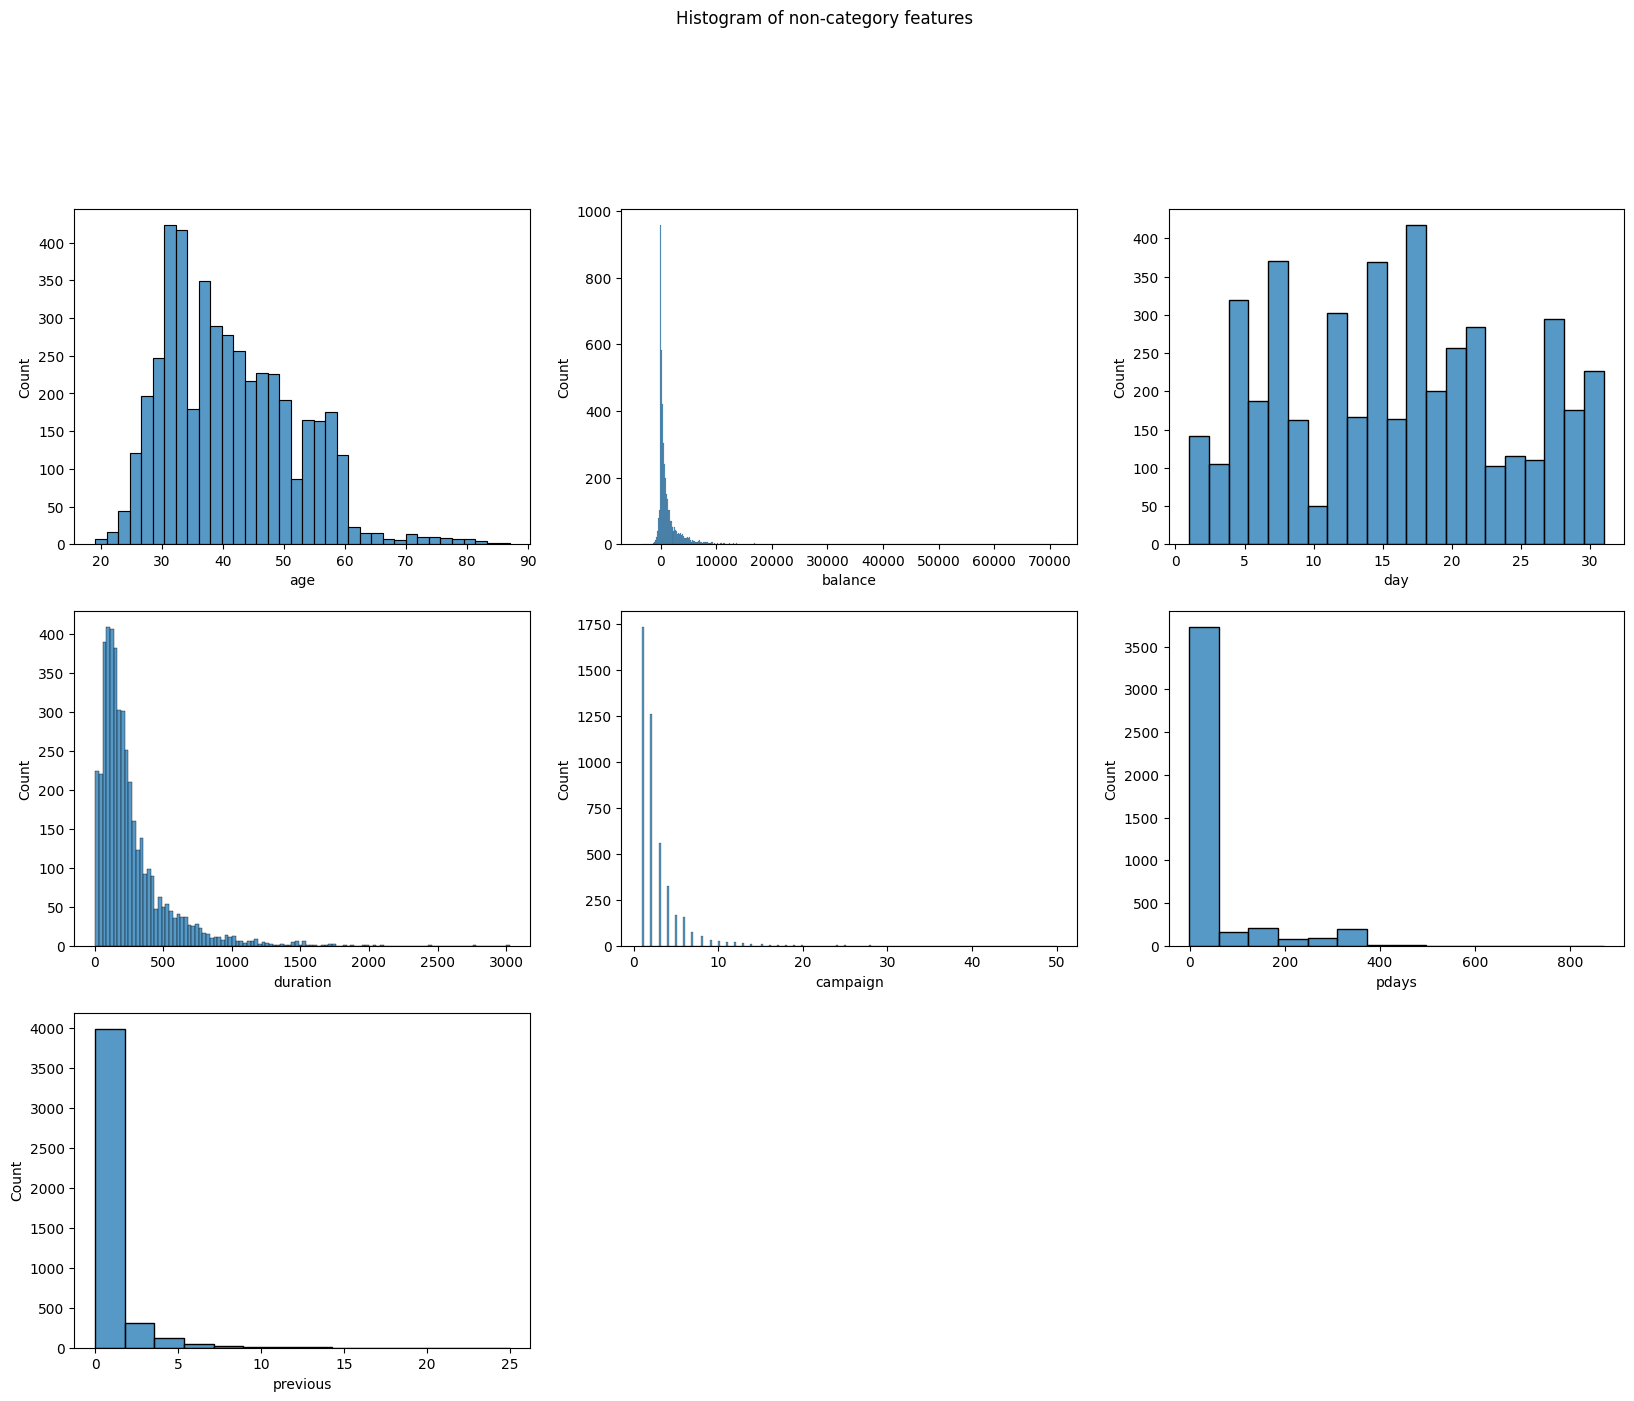

In [31]:
# plot the non-category features
non_category_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
# create subplots to allow printing of all the countplots in one figure 
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

# loop through the category features and plot the countplot
for category in non_category_features:
    sns.histplot(x=category, data=data, ax=axes[non_category_features.index(category) // 3, non_category_features.index(category) % 3])
for i in range(len(non_category_features), len(axes.flat)):
    fig.delaxes(axes.flatten()[i])
plt.suptitle('Histogram of non-category features')
plt.show()



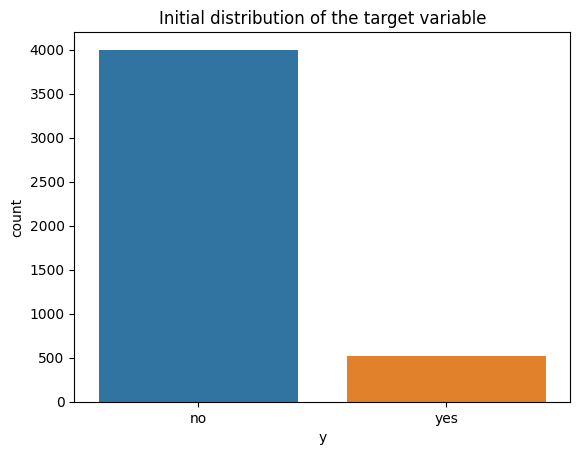

In [32]:
# get the current distribution of the target variable (y)
sns.countplot(x='y', data=data)
plt.title('Initial distribution of the target variable')
plt.show()


# Data Encoding

In [33]:
# perfomr one-hot encoding on the categorical features
hot_data = pd.get_dummies(data, columns=category_features[:-1], drop_first=True)
hot_data.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,no,False,False,...,False,False,False,False,False,True,False,False,False,True
1,33,4789,11,220,1,339,4,no,False,False,...,False,False,False,True,False,False,False,False,False,False
2,35,1350,16,185,1,330,1,no,False,False,...,False,False,False,False,False,False,False,False,False,False
3,30,1476,3,199,4,-1,0,no,False,False,...,False,True,False,False,False,False,False,False,False,True
4,59,0,5,226,1,-1,0,no,True,False,...,False,False,False,True,False,False,False,False,False,True


### Observation1

* using one-hot encoding increases the columns from 17 columns to 43 columns. 
* While we've dropped some of the binary variables created (9) to reduce multicollinerity, this is still a significant increase in data frame dimension. 
* The following cell performs label encoding to explore an alternative to one-hot encoding

In [37]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in category_features:
    data[column] = le.fit_transform(data[column])
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


In [45]:
# Seperate the input data from the target variable y
x = data.iloc[:,:-1]
y = data.iloc[:, -1]
x.head()
y.head()


0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [48]:
print(x.shape, y.shape)

(4521, 16) (4521,)


In [54]:
# Explore the concept of oversampling and undersampling
# check the counts of the target variables to see distribution of the targets
# pandas.value_counts to get the unique values in target var
print(y.value_counts())

y
0    4000
1     521
Name: count, dtype: int64


## Observation 2
* It is clear that the target variable (y) has a high level of imbalance
* There are 4000 instances of 0 (no loan approval) and only 521 (Loan approved)
* This **class imbalance** could potentially lead to false accuracy metrics as the resulting model may be biased towards the majority class
* *Remedy* is to use an oversampling technique to synthetically increase the minority class.
* *Trade off;* Oversampling may expose the model to overfitting. Use regularization and cross validation to reduce overfitting